# Football Match Predictor - Modelling

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import data_cleaning
import feature_engineering

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin

## Importing, cleaning data and feature engineering

In [2]:
# Import all the data and merge into one data frame
merged_data_df = data_cleaning.import_and_merge_data_pipeline()

# Clean all the data
cleaned_df = data_cleaning.clean_data_pipeline(merged_data_df)

# feature engineering
home_away_features_df = feature_engineering.generate_home_away_features(cleaned_df)
home_data_transformed, away_data_transformed = feature_engineering.generate_team_season_features(cleaned_df)

transformed_df = (home_away_features_df
    .join(home_data_transformed)
    .join(away_data_transformed)
)

## Creating test set 

In [3]:
features_cols = ['season_year', 'match_round',
       'capacity', 'missing_cards', 'missing_elo',
       'home_elo', 'away_elo', 'home_team_home_form', 'away_team_away_form',
       'home_team_home_total_goals', 'away_team_away_total_goals', 'home_form',
       'home_total_goals', 'home_discipline', 'away_form', 'away_total_goals',
       'away_discipline']

target_col = 'result'

In [4]:
# Look at percentage of all data points per year and use roughly last 20% for test set
((transformed_df
        .groupby('season_year')
        .result
        .count())
    .div(transformed_df
        .result
        .count())
    .mul(100)
    .cumsum()
    .loc[2004:]
)

season_year
2004     48.478621
2005     51.677962
2006     54.737847
2007     57.797731
2008     60.857616
2009     63.917501
2010     66.977385
2011     70.036454
2012     73.095524
2013     76.152962
2014     79.212846
2015     82.264576
2016     85.316305
2017     88.368034
2018     91.419764
2019     94.373629
2020     97.142368
2021    100.000000
Name: result, dtype: float64

In [5]:
# Use roughly 80/20 split for train_test_split
train = transformed_df.query("season_year <= 2014")
test = transformed_df.query("season_year >= 2015")

100*train.shape[0]/transformed_df.shape[0], 100*test.shape[0]/transformed_df.shape[0]

(79.21284629625099, 20.787153703749013)

In [6]:
# Create a validation set
train_train = train.query("season_year <= 2008")
train_valid = train.query("season_year >= 2009")

100*train_train.shape[0]/transformed_df.shape[0], 100*train_valid.shape[0]/transformed_df.shape[0]

(60.857615867035285, 18.355230429215702)

# Logistic Regression - Baseline Score

In [7]:
X_train = train_train[features_cols]
y_train = train_train.result

X_valid = train_valid[features_cols]
y_valid = train_valid.result

/tmp/ipykernel_59557/3969413269.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X_train.hist(ax=ax, bins=20);


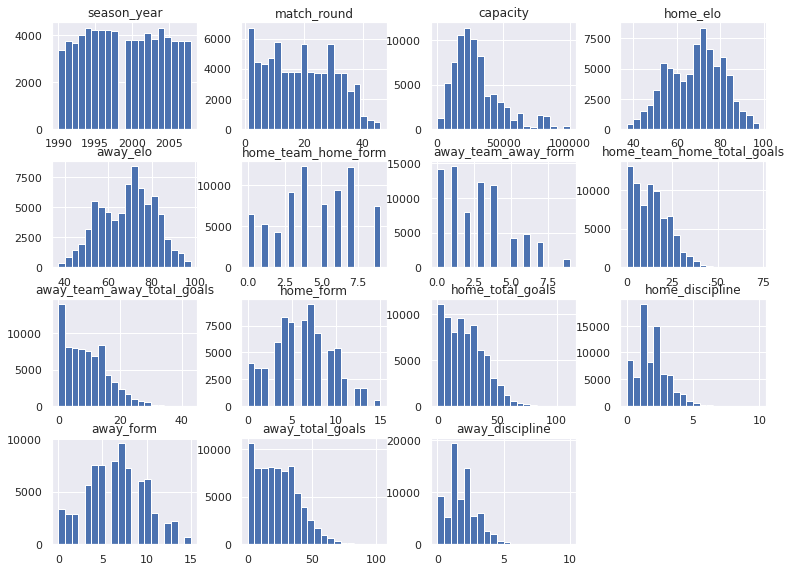

In [8]:
fig, ax = plt.subplots(figsize=(12.8, 9.6))

X_train.hist(ax=ax, bins=20);

In [9]:
# std_scaler_log_reg = Pipeline([('std_scaler', StandardScaler()),
#                         ('logistic_regression', LogisticRegression())])
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

std_scaled_X_train = std_scaler.fit_transform(X_train)
min_max_scaled_X_train = min_max_scaler.fit_transform(X_train)

lr_model_std_scaled = LogisticRegression()
lr_model_std_scaled.fit(std_scaled_X_train, y_train)

lr_model_min_max_scaled = LogisticRegression(max_iter=200)
lr_model_min_max_scaled.fit(min_max_scaled_X_train, y_train);

In [10]:
std_scaled_valid = std_scaler.transform(X_valid)
accuracy_score(y_valid, lr_model_std_scaled.predict(std_scaled_valid))

0.49073621539965345

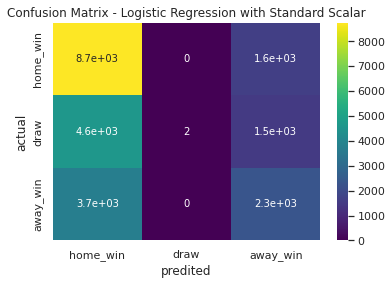

In [11]:
labels = ['home_win', 'draw', 'away_win']
confusion_matrix_std_scaled = confusion_matrix(y_valid, lr_model_std_scaled.predict(std_scaled_valid), labels=labels)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix_std_scaled, annot=True, cmap='viridis', 
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('predited')
ax.set_ylabel('actual')
ax.set_title('Confusion Matrix - Logistic Regression with Standard Scalar');

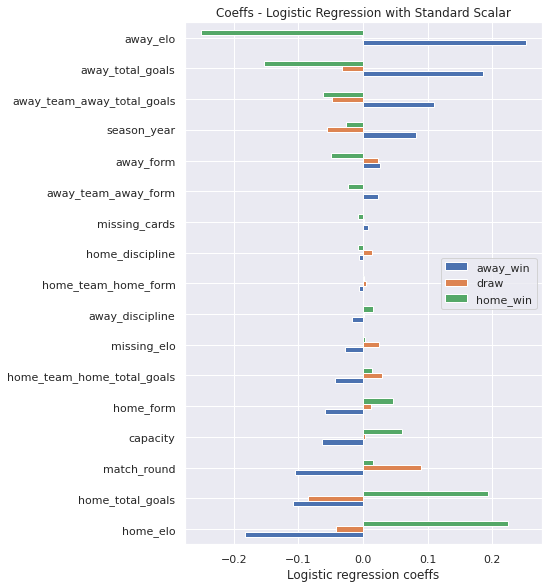

In [12]:
lr_model_std_scaled_coefs = pd.DataFrame(lr_model_std_scaled.coef_, columns=X_train.columns).T.rename(columns={i: lr_model_std_scaled.classes_[i] for i in range(3)})

fig, ax = plt.subplots(figsize=(6.4, 9.6))
lr_model_std_scaled_coefs.sort_values(by='away_win').plot.barh(ax=ax)
ax.set_xlabel('Logistic regression coeffs')
ax.set_title('Coeffs - Logistic Regression with Standard Scalar');

In [13]:
min_max_scaled_valid = min_max_scaler.transform(X_valid)
accuracy_score(y_valid, lr_model_min_max_scaled.predict(min_max_scaled_valid))

0.49100279912915984

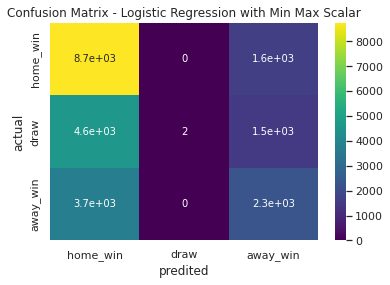

In [14]:
labels = ['home_win', 'draw', 'away_win']
confusion_matrix_min_max_scaled = confusion_matrix(y_valid, lr_model_min_max_scaled.predict(min_max_scaled_valid), labels=labels)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix_min_max_scaled, annot=True, cmap='viridis', 
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('predited')
ax.set_ylabel('actual')
ax.set_title('Confusion Matrix - Logistic Regression with Min Max Scalar');

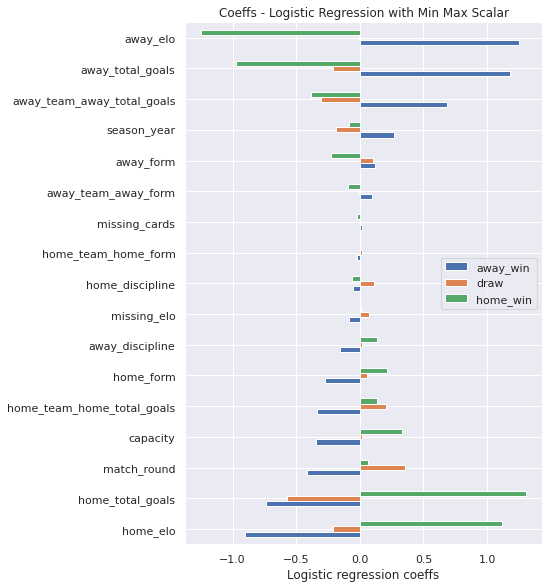

In [15]:
lr_model_min_max_scaled_coefs = pd.DataFrame(lr_model_min_max_scaled.coef_, columns=X_train.columns).T.rename(columns={i: lr_model_min_max_scaled.classes_[i] for i in range(3)})

fig, ax = plt.subplots(figsize=(6.4, 9.6))
lr_model_min_max_scaled_coefs.sort_values(by='away_win').plot.barh(ax=ax)
ax.set_xlabel('Logistic regression coeffs')
ax.set_title('Coeffs - Logistic Regression with Min Max Scalar');

In [16]:
X_train_new = (X_train
                .assign(elo_diff = X_train.home_elo - X_train.away_elo,
                        team_home_away_form_diff = X_train.home_team_home_form - X_train.away_team_away_form,
                        team_home_away_total_goals_diff = X_train.home_team_home_form - X_train.away_team_away_total_goals,
                        form_diff = X_train.home_form - X_train.away_form,
                        total_goals_diff = X_train.home_total_goals - X_train.away_total_goals,
                        discipline_diff = X_train.home_discipline - X_train.away_discipline)
                .drop(columns=['home_elo', 'away_elo', 'home_team_home_form',
                                'away_team_away_form', 'home_team_home_total_goals',
                                'away_team_away_total_goals', 'home_form', 'home_total_goals',
                                'home_discipline', 'away_form', 'away_total_goals', 'away_discipline'])
)

X_valid_new = (X_valid
                .assign(elo_diff = X_valid.home_elo - X_valid.away_elo,
                        team_home_away_form_diff = X_valid.home_team_home_form - X_valid.away_team_away_form,
                        team_home_away_total_goals_diff = X_valid.home_team_home_form - X_valid.away_team_away_total_goals,
                        form_diff = X_valid.home_form - X_valid.away_form,
                        total_goals_diff = X_valid.home_total_goals - X_valid.away_total_goals,
                        discipline_diff = X_valid.home_discipline - X_valid.away_discipline)
                .drop(columns=['home_elo', 'away_elo', 'home_team_home_form',
                                'away_team_away_form', 'home_team_home_total_goals',
                                'away_team_away_total_goals', 'home_form', 'home_total_goals',
                                'home_discipline', 'away_form', 'away_total_goals', 'away_discipline'])
)

In [17]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

std_scaled_X_train = std_scaler.fit_transform(X_train_new)
min_max_scaled_X_train = min_max_scaler.fit_transform(X_train_new)

lr_model_std_scaled = LogisticRegression()
lr_model_std_scaled.fit(std_scaled_X_train, y_train)

lr_model_min_max_scaled = LogisticRegression(max_iter=200)
lr_model_min_max_scaled.fit(min_max_scaled_X_train, y_train);

In [18]:
std_scaled_valid = std_scaler.transform(X_valid_new)
min_max_scaled_valid = min_max_scaler.transform(X_valid_new)

accuracy_score(y_valid, lr_model_std_scaled.predict(std_scaled_valid)), accuracy_score(y_valid, lr_model_min_max_scaled.predict(min_max_scaled_valid))

(0.48935886613053714, 0.48944772737370595)

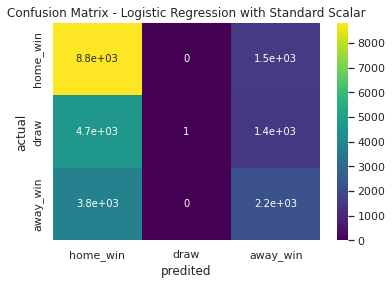

In [19]:
labels = ['home_win', 'draw', 'away_win']
confusion_matrix_std_scaled = confusion_matrix(y_valid, lr_model_std_scaled.predict(std_scaled_valid), labels=labels)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix_std_scaled, annot=True, cmap='viridis', 
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('predited')
ax.set_ylabel('actual')
ax.set_title('Confusion Matrix - Logistic Regression with Standard Scalar');

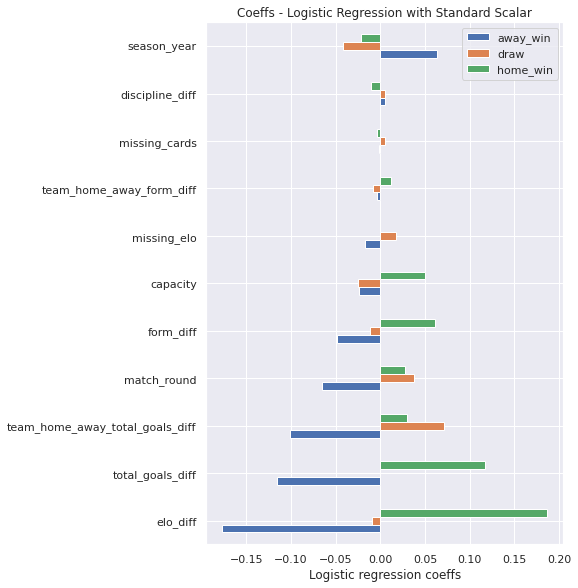

In [20]:
lr_model_std_scaled_coefs = pd.DataFrame(lr_model_std_scaled.coef_, columns=X_train_new.columns).T.rename(columns={i: lr_model_std_scaled.classes_[i] for i in range(3)})

fig, ax = plt.subplots(figsize=(6.4, 9.6))
lr_model_std_scaled_coefs.sort_values(by='away_win').plot.barh(ax=ax)
ax.set_xlabel('Logistic regression coeffs')
ax.set_title('Coeffs - Logistic Regression with Standard Scalar');

In [21]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid))

0.47003154574132494

In [22]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_new, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid_new))

0.46772115341893633

In [23]:
params={'n_estimators': hp.choice('n_estimators', np.arange(100, 501, dtype=int)),
           'max_depth': hp.choice('max_depth', np.arange(5, 21, dtype=int)),
           'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 11, dtype=int)),
           'min_samples_split': hp.choice('min_samples_split', np.arange(2, 21, dtype=int))}

def hyperparameter_tuning(params):

    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_valid, clf.predict(X_valid))
    return -acc

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = params,
    algo=tpe.suggest,
    max_evals=24,
    trials=trials
)

# print("Best: {}".format(best))
best

100%|██████████| 24/24 [06:51<00:00, 17.13s/trial, best loss: -0.4913138134802506]


{'max_depth': 9,
 'min_samples_leaf': 6,
 'min_samples_split': 12,
 'n_estimators': 390}

In [24]:
rf_clf = RandomForestClassifier(**best, random_state=42)
rf_clf.fit(X_train, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid))

0.48935886613053714

<AxesSubplot:>

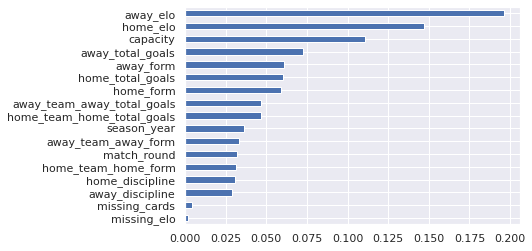

In [25]:
feature_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feature_importances.sort_values().plot.barh()

In [26]:
params={'n_estimators': hp.choice('n_estimators', np.arange(100, 501, dtype=int)),
           'max_depth': hp.choice('max_depth', np.arange(5, 21, dtype=int)),
           'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 11, dtype=int)),
           'min_samples_split': hp.choice('min_samples_split', np.arange(2, 21, dtype=int))}

def hyperparameter_tuning(params):

    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    clf.fit(X_train_new, y_train)
    acc = accuracy_score(y_valid, clf.predict(X_valid_new))
    return -acc

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = params,
    algo=tpe.suggest,
    max_evals=24,
    trials=trials
)

# print("Best: {}".format(best))
best

100%|██████████| 24/24 [04:31<00:00, 11.33s/trial, best loss: -0.49180255031767894]


{'max_depth': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 7,
 'n_estimators': 94}

In [27]:
rf_clf = RandomForestClassifier(**best, random_state=42)
rf_clf.fit(X_train_new, y_train)
accuracy_score(y_valid, rf_clf.predict(X_valid_new))

0.4877149331319145

<AxesSubplot:>

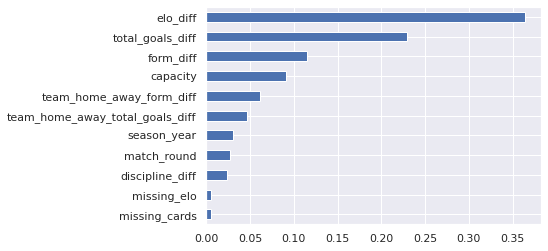

In [28]:
feature_importances = pd.Series(rf_clf.feature_importances_, index=X_train_new.columns)
feature_importances.sort_values().plot.barh()

## Leave one feature out - feature selection